In [1]:
from init import *
from utility import *
from repro import readfile

autotime loaded.
black loaded.
black loaded.
time: 915 ms


<IPython.core.display.Javascript object>

In [2]:
class Reprobus:
    def __init__(self, filename, nbcon=44, ncm=15, islev=np.arange(350, 801, 5)):
        p0, rascp = 1000.0, 2.0 / 7.0
        self.filename = filename
        self.date = pd.to_datetime(filename.split("_")[2], format="%Y%m%d%H")
        if self.date > pd.to_datetime("2019-07-31"):
            self.nlev = 137
        else:
            self.nlev = 60
        nlev = self.nlev
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in np.arange(nlev):
            pmb[:, :, i] = aa[i] + bb[i] * pj1
        theta = tj1 * ((p0 / pmb) ** rascp)

        tr1 = {"Ozone": 4, "ClO": 10, "NO2": 6}
        tr2 = {
            "HNO3g": 42,
            "HNO3": 3,
            "N2O": 0,
            "POx": 10,
            "ClONO2": 13,
            "NOx": 20,
            "ClOx": 22,
            "BrOx": 23,
            "HCl": 12,
        }
        self.long_name = {
            "Ozone": "O$_3$",
            "ClO": "ClO",
            "HNO3g": "HNO$_3$ Gas",
            "HNO3": "HNO$_3$",
            "N2O": "N$_2$O",
            "NO2": "NO$_2$",
            "POx": "Passive Ox",
            "ClONO2": "ClONO$_2$",
            "NOx": "NO$_x$",
            "ClOx": "ClO$_x$",
            "BrOx": "BrO$_x$",
            "HCl": "HCl",
        }

        data = xr.Dataset()

        for k, v in tr1.items():
            data[k] = self.isentropic_tracers(hc[:, :, :, v], theta, islev, k)

        for k, v in tr2.items():
            data[k] = self.isentropic_tracers(qj1[:, :, :, v], theta, islev, k)

        self.data = data

    def get_coeffs(self, cdir="."):
        cfile = "%s/ecmwf_%s_levels.txt" % (cdir, self.nlev)
        df = pd.read_csv(cfile, sep="\s+", skiprows=[1])
        aa = 0.01 * df["a"].rolling(1).mean()[1:].values
        bb = df["b"].rolling(1).mean()[1:].values
        return aa, bb

    def isentropic_tracers(self, tmp, theta, islev, tr):
        lats = xr.DataArray(
            np.arange(90, -91, -2), dims="Latitude", attrs={"long_name": "Latitude"}
        )
        lons = xr.DataArray(
            np.arange(0, 360, 2), dims="Longitude", attrs={"long_name": "Longitude"}
        )
        levs = np.arange(self.nlev)  # [::-1]

        coords = [lons, lats, levs]
        dims = ["Longitude", "Latitude", "Level"]
        tattrs = {"long_name": "Temperature", "units": "K"}

        theta = xr.DataArray(theta, coords=coords, dims=dims, attrs=tattrs)
        islev = xr.DataArray(islev, dims="Theta", attrs=tattrs)
        tmp = xr.DataArray(tmp / 1e-9, dims=dims, coords=coords)
        tmp = xrvinterp(tmp, theta, islev, "Level", "Theta")
        tmp.attrs = {"long_name": "%s [ppbv]" % self.long_name[tr]}
        return tmp

time: 5.14 ms


<IPython.core.display.Javascript object>

In [3]:
def get_basemap(ax=None, min_lat=30):
    if not ax:
        fig, ax = facets(1, 1, width=10, aspect=0.6)
        ax = ax[0]
    m = Basemap(projection="spstere", lon_0=180, boundinglat=min_lat, round=True, ax=ax)
    m.drawcoastlines(linewidth=0.35)
    m.drawcountries(linewidth=0.35)
    m.drawmeridians(np.arange(0, 360, 60), labels=[0, 0, 0, 0])
    m.drawparallels(np.arange(20, 80, 20), labels=[1, 1, 0, 0])
    return m


def plot_data(molz, level=475, scale=1, min_lat=-45):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    m = get_basemap(ax=ax, min_lat=min_lat)
    data = molz.sel(Theta=level, method="nearest").T.values
    data, lon = addcyclic(data, molz["Longitude"])
    lat, lon = np.meshgrid(molz["Latitude"], lon)
    lon, lat = m(lon, lat)
    im = m.contourf(lon, lat, scale * data.T)
    cb = plt.colorbar(im, cax=cax, orientation="vertical")
    # cb.set_label(label="%s" % (molz.attrs["long_name"]), size=18)
    return fig, ax, cb

time: 2.12 ms


<IPython.core.display.Javascript object>

In [4]:
odir = "/media/pankaj/Data/reprobus/netcdf/"
files = sorted(glob.glob("/media/pankaj/Data/reprobus/bin/*"))
for filename in files:
    bus = Reprobus(filename)
    ncfile = f"%s%s.nc" % (odir, bus.date.isoformat().split("T")[0])
    print(f"Saving %s" % ncfile)
    bus.data[["Ozone", "POx"]].to_netcdf(ncfile)

Saving /media/pankaj/Data/reprobus/netcdf/2015-05-01.nc
Saving /media/pankaj/Data/reprobus/netcdf/2015-05-02.nc
Saving /media/pankaj/Data/reprobus/netcdf/2015-05-03.nc
Saving /media/pankaj/Data/reprobus/netcdf/2015-05-04.nc
Saving /media/pankaj/Data/reprobus/netcdf/2015-05-05.nc
Saving /media/pankaj/Data/reprobus/netcdf/2015-05-06.nc
time: 3min 44s


<IPython.core.display.Javascript object>

In [5]:
bus.data

<xarray.Dataset>
Dimensions:    (Latitude: 91, Longitude: 180, Theta: 91)
Coordinates:
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Data variables:
    Ozone      (Longitude, Latitude, Theta) float64 532.2 586.7 ... 2.995e+03
    ClO        (Longitude, Latitude, Theta) float64 0.0005353 ... 4.55e-06
    NO2        (Longitude, Latitude, Theta) float64 0.1402 0.161 ... 2.317 2.401
    HNO3g      (Longitude, Latitude, Theta) float64 1.561 1.694 ... 9.909 9.698
    HNO3       (Longitude, Latitude, Theta) float64 1.864 2.033 ... 16.19 16.16
    N2O        (Longitude, Latitude, Theta) float64 303.3 300.3 ... 7.929 7.633
    POx        (Longitude, Latitude, Theta) float64 563.8 627.9 ... 6.142e+03
    ClONO2     (Longitude, Latitude, Theta) float64 0.03208 0.03795 ... 0.4862
    NOx        (Longitude, Latitude, Theta) float64 0.2157 0.2438 ... 2.32 2.404
    ClOx       (Longitude, Latitude, Theta) float64 0.0005354 ... 4.55e-06
    BrOx       (Longitude, Latitude, Theta) float64 0.001775 ... 2.081e-13
    HCl        (Longitude, Latitude, Theta) float64 0.4276 0.4639 ... 2.584

time: 48.7 ms


<IPython.core.display.Javascript object>

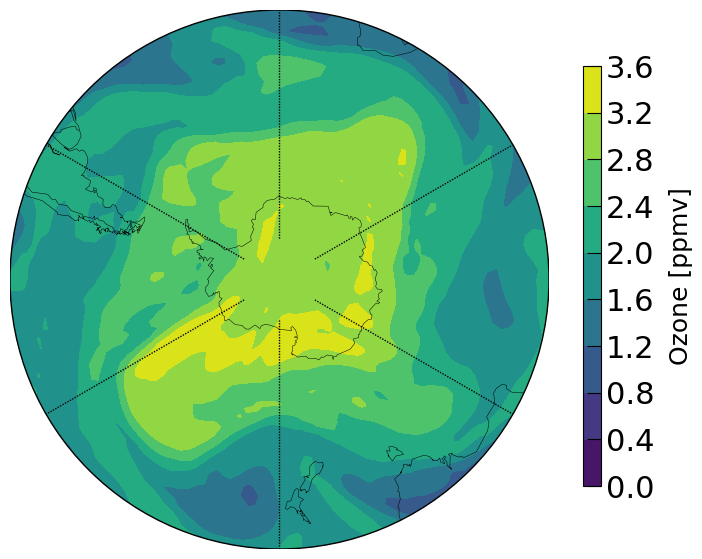

time: 438 ms


<IPython.core.display.Javascript object>

In [6]:
fig, ax, cb = plot_data(bus.data["Ozone"], level=475, scale=0.001, min_lat=-30)
cb.set_label(label="%s" % ("Ozone [ppmv]"), size=18)
# plt.savefig("/home/pankaj/Desktop/repro_ozone_435K.png", bbox_inches="tight")
plt.show()

In [9]:
bus.data["Ozone"]

<xarray.DataArray 'Ozone' (Longitude: 180, Latitude: 91, Theta: 91)>
array([[[ 532.2406944 ,  586.68893127,  641.13716814, ...,
         4187.11116763, 4187.49052472, 4202.40057965],
        [ 492.04968815,  547.56767501,  603.08566186, ...,
         4315.06737184, 4327.65978885, 4344.28705484],
        [ 475.1367515 ,  515.46567147,  555.79459143, ...,
         4486.97125365, 4491.02290715, 4504.65114267],
        ...,
        [ 215.57972381,  246.92260894,  283.91989214, ...,
         2898.29407929, 2918.94330144, 2939.5925236 ],
        [ 206.13930269,  242.57374313,  279.34582537, ...,
         2855.24372942, 2882.20959403, 2909.17545864],
        [ 188.29038535,  238.08341401,  278.86594507, ...,
         2936.455753  , 2965.81185249, 2995.16795198]],

       [[ 532.24071115,  586.68894104,  641.13717093, ...,
         4187.11116753, 4187.49052439, 4202.4005793 ],
        [ 492.85732879,  549.49428658,  606.13124438, ...,
         4315.45085702, 4328.20326235, 4344.75379967],
        [ 477.23746096,  517.177574  ,  557.11768705, ...,
         4486.2653981 , 4490.78023788, 4504.15839417],
...
        [ 212.75865241,  243.71237774,  281.14808633, ...,
         2936.27263038, 2956.00132125, 2975.73001212],
        [ 203.03810205,  241.66075507,  278.18207143, ...,
         2864.95281599, 2890.85226736, 2916.75171873],
        [ 188.29038628,  238.08341509,  278.86594472, ...,
         2936.45575111, 2965.81185057, 2995.16795003]],

       [[ 532.24067834,  586.68892326,  641.13716818, ...,
         4187.11116553, 4187.49052294, 4202.40057826],
        [ 491.43629846,  545.7865596 ,  600.13682074, ...,
         4314.52556351, 4326.93611129, 4343.64531751],
        [ 473.55235902,  514.90699702,  556.26163501, ...,
         4487.3337358 , 4490.94685705, 4504.85010075],
        ...,
        [ 213.86020106,  245.08196893,  282.48107397, ...,
         2917.02540725, 2937.16787198, 2957.31033671],
        [ 205.02056391,  242.60585557,  279.19603507, ...,
         2860.08587572, 2886.50472054, 2912.92356536],
        [ 188.2903859 ,  238.08341484,  278.86594383, ...,
         2936.45575046, 2965.81185015, 2995.16794984]]])
Coordinates:
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Attributes:
    long_name:  O$_3$ [ppbv]

time: 25.7 ms


<IPython.core.display.Javascript object>